# Best pinch hitters inside PP in the IPL so far (min of 20 ings)

In [2]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

In [31]:
deliveries = pd.read_csv('deliveries.csv')
matches = pd.read_csv('matches.csv')

In [4]:
deliveries.head(2)

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN


In [32]:
matches.head(2)

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,2017,Hyderabad,05-04-2017,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN
1,2,2017,Pune,06-04-2017,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN


## Terminology Used:
- SR = Strike Rate = Scoring rate for each ball
- RPI = Runs Per Innings = Runs scored per each innings including outs/not-outs
- BPB = Balls Per Boundary = No of balls for each six or a four
- BPD = Balls Per Dismissal = Average number of balls faced per each dismissal

## Part 1: Player Statistics
### 1.1 : Extract player-level statistics
### 1.2 : Determine player type from the above stats

In [5]:
def balls_per_dismissal(balls, dismissals):
    if dismissals > 0:
        return balls/dismissals
    else:
        return balls/1 
    
def balls_per_boundary(balls, boundaries):
    if boundaries > 0:
        return balls/boundaries
    else:
        return balls/1 

def playerStatistics(df):
    
    df['isDot'] = df['batsman_runs'].apply(lambda x: 1 if x == 0 else 0)
    df['isOne'] = df['batsman_runs'].apply(lambda x: 1 if x == 1 else 0)
    df['isTwo'] = df['batsman_runs'].apply(lambda x: 1 if x == 2 else 0)
    df['isThree'] = df['batsman_runs'].apply(lambda x: 1 if x == 3 else 0)
    df['isFour'] = df['batsman_runs'].apply(lambda x: 1 if x == 4 else 0)
    df['isSix'] = df['batsman_runs'].apply(lambda x: 1 if x == 6 else 0)
    
    runs = pd.DataFrame(df.groupby(['batsman', 'match_id'])['batsman_runs'].sum().reset_index()).groupby(['batsman'])['batsman_runs'].sum().reset_index().rename(columns={'batsman_runs':'runs'})
    innings = pd.DataFrame(df.groupby(['batsman'])['match_id'].apply(lambda x: len(list(np.unique(x)))).reset_index()).rename(columns = {'match_id':'innings'})
    balls = pd.DataFrame(df.groupby(['batsman'])['match_id'].count()).reset_index().rename(columns = {'match_id':'balls'})
    dismissals = pd.DataFrame(df.groupby(['batsman'])['player_dismissed'].count()).reset_index().rename(columns = {'player_dismissed':'dismissals'})
    
    dots = pd.DataFrame(df.groupby(['batsman'])['isDot'].sum()).reset_index().rename(columns = {'isDot':'dots'})
    ones = pd.DataFrame(df.groupby(['batsman'])['isOne'].sum()).reset_index().rename(columns = {'isOne':'ones'})
    twos = pd.DataFrame(df.groupby(['batsman'])['isTwo'].sum()).reset_index().rename(columns = {'isTwo':'twos'})
    threes = pd.DataFrame(df.groupby(['batsman'])['isThree'].sum()).reset_index().rename(columns = {'isThree':'threes'})
    fours = pd.DataFrame(df.groupby(['batsman'])['isFour'].sum()).reset_index().rename(columns = {'isFour':'fours'})
    sixes = pd.DataFrame(df.groupby(['batsman'])['isSix'].sum()).reset_index().rename(columns = {'isSix':'sixes'})
    
    df = pd.merge(innings, runs, on = 'batsman').merge(balls, on = 'batsman').merge(dismissals, on = 'batsman').merge(dots, on = 'batsman').merge(ones, on = 'batsman').merge(twos, on = 'batsman').merge(threes, on = 'batsman').merge(fours, on = 'batsman').merge(sixes, on = 'batsman')
    
    #StrikeRate
    df['SR'] = df.apply(lambda x: 100*(x['runs']/x['balls']), axis = 1)

    #runs per innings
    df['RPI'] = df.apply(lambda x: x['runs']/x['innings'], axis = 1)

    #balls per dismissals
    df['BPD'] = df.apply(lambda x: balls_per_dismissal(x['balls'], x['dismissals']), axis = 1)

    #balls per boundary
    df['BPB'] = df.apply(lambda x: balls_per_boundary(x['balls'], (x['fours'] + x['sixes'])), axis = 1)
    
    return df

In [6]:
df = playerStatistics(deliveries)

In [7]:
df.head()

,batsman,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,SR,RPI,BPD,BPB
0,A Ashish Reddy,23,280,196,15,61,83,20,1,16,15,142.857143,12.173913,13.066667,6.322581
1,A Chandila,2,4,7,1,3,4,0,0,0,0,57.142857,2.000000,7.000000,7.000000
2,A Chopra,6,53,75,5,45,21,2,0,7,0,70.666667,8.833333,15.000000,10.714286
3,A Choudhary,3,25,20,2,4,13,1,0,1,1,125.000000,8.333333,10.000000,10.000000
4,A Dananjaya,1,4,5,0,2,2,1,0,0,0,80.000000,4.000000,5.000000,5.000000


## 1.3 : Performance in different phases of play

In [8]:
def phase(over):
    if over <= 5:
        return 'Powerplay'
    elif over <= 14:
        return 'Middle'
    else:
        return 'Death'

In [9]:
deliveries['phase'] = deliveries['over'].apply(lambda x: phase(x))

In [10]:
def phasesOfplay(df, current_phase):
    
    df = df[df.phase == current_phase]
    df.reset_index(inplace = True, drop = True)
    
    df['isDot'] = df['batsman_runs'].apply(lambda x: 1 if x == 0 else 0)
    df['isOne'] = df['batsman_runs'].apply(lambda x: 1 if x == 1 else 0)
    df['isTwo'] = df['batsman_runs'].apply(lambda x: 1 if x == 2 else 0)
    df['isThree'] = df['batsman_runs'].apply(lambda x: 1 if x == 3 else 0)
    df['isFour'] = df['batsman_runs'].apply(lambda x: 1 if x == 4 else 0)
    df['isSix'] = df['batsman_runs'].apply(lambda x: 1 if x == 6 else 0)
    
    runs = pd.DataFrame(df.groupby(['batsman', 'match_id'])['batsman_runs'].sum().reset_index()).groupby(['batsman'])['batsman_runs'].sum().reset_index().rename(columns={'batsman_runs':'runs'})
    innings = pd.DataFrame(df.groupby(['batsman'])['match_id'].apply(lambda x: len(list(np.unique(x)))).reset_index()).rename(columns = {'match_id':'innings'})
    balls = pd.DataFrame(df.groupby(['batsman'])['match_id'].count()).reset_index().rename(columns = {'match_id':'balls'})
    dismissals = pd.DataFrame(df.groupby(['batsman'])['player_dismissed'].count()).reset_index().rename(columns = {'player_dismissed':'dismissals'})
    
    dots = pd.DataFrame(df.groupby(['batsman'])['isDot'].sum()).reset_index().rename(columns = {'isDot':'dots'})
    ones = pd.DataFrame(df.groupby(['batsman'])['isOne'].sum()).reset_index().rename(columns = {'isOne':'ones'})
    twos = pd.DataFrame(df.groupby(['batsman'])['isTwo'].sum()).reset_index().rename(columns = {'isTwo':'twos'})
    threes = pd.DataFrame(df.groupby(['batsman'])['isThree'].sum()).reset_index().rename(columns = {'isThree':'threes'})
    fours = pd.DataFrame(df.groupby(['batsman'])['isFour'].sum()).reset_index().rename(columns = {'isFour':'fours'})
    sixes = pd.DataFrame(df.groupby(['batsman'])['isSix'].sum()).reset_index().rename(columns = {'isSix':'sixes'})
    
    df = pd.merge(innings, runs, on = 'batsman').merge(balls, on = 'batsman').merge(dismissals, on = 'batsman').merge(dots, on = 'batsman').merge(ones, on = 'batsman').merge(twos, on = 'batsman').merge(threes, on = 'batsman').merge(fours, on = 'batsman').merge(sixes, on = 'batsman')
    
    #StrikeRate
    df['SR'] = df.apply(lambda x: 100*(x['runs']/x['balls']), axis = 1)

    #runs per innings
    df['RPI'] = df.apply(lambda x: x['runs']/x['innings'], axis = 1)

    #balls per dismissals
    df['BPD'] = df.apply(lambda x: balls_per_dismissal(x['balls'], x['dismissals']), axis = 1)

    #balls per boundary
    df['BPB'] = df.apply(lambda x: balls_per_boundary(x['balls'], (x['fours'] + x['sixes'])), axis = 1)
    
    return df

In [11]:
pp_df = phasesOfplay(deliveries, 'Powerplay')
mid_df = phasesOfplay(deliveries, 'Middle')
dth_df = phasesOfplay(deliveries, 'Death')

In [12]:
pp_df.head(2)

,batsman,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,SR,RPI,BPD,BPB
0,A Ashish Reddy,1,0,2,0,2,0,0,0,0,0,0.00,0.0,2.0,2.0
1,A Chopra,4,18,32,1,20,10,0,0,2,0,56.25,4.5,32.0,16.0


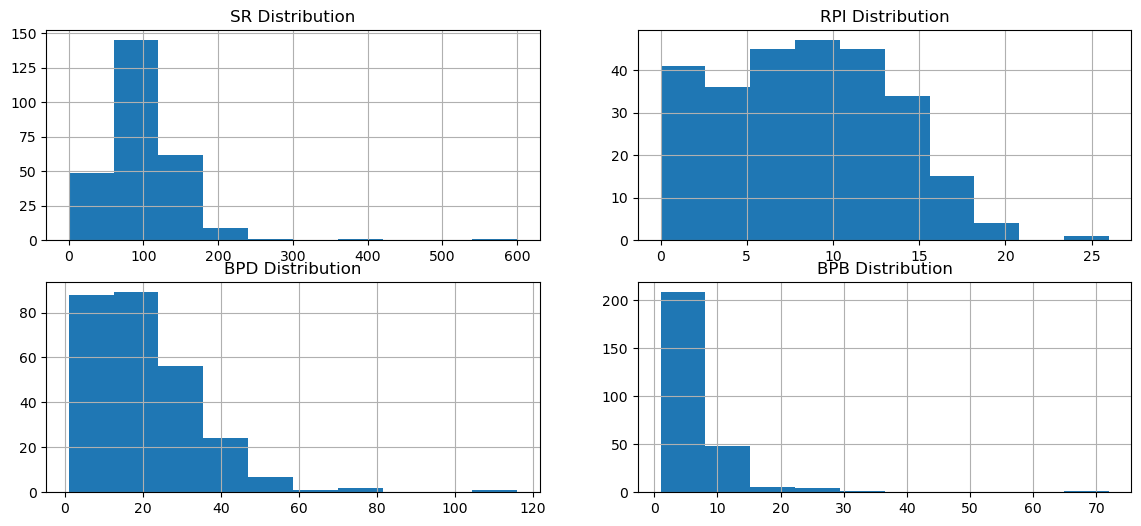

In [14]:
plt.figure(figsize = (14, 6))

plt.subplot(221)
pp_df.SR.hist()
plt.title('SR Distribution')

plt.subplot(222)
pp_df.RPI.hist()
plt.title('RPI Distribution')

plt.subplot(223)
pp_df.BPD.hist()
plt.title('BPD Distribution')

plt.subplot(224)
pp_df.BPB.hist()
plt.title('BPB Distribution')

plt.show()

## Pair wise comparision matrices using Saaty scale & then arriving at weights for each parameter

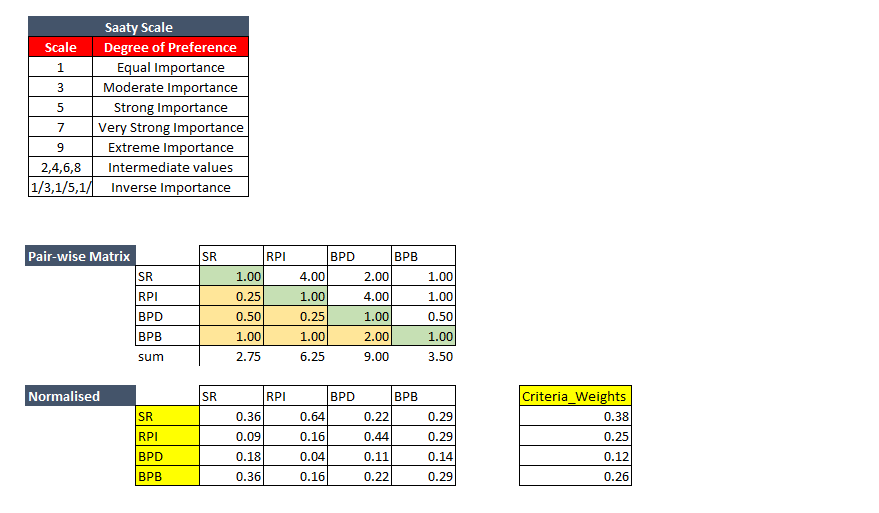

In [20]:
# from IPython.display import Image

# # Display the image
# Image("image.png")


In [21]:
wt_sr, wt_rpi, wt_bpd, wt_bpb = 0.38, 0.25, 0.12, 0.26

In [22]:
# filter by min 20 innings
pp_df = pp_df[pp_df.innings > 20]
pp_df.reset_index(inplace = True, drop = True)

## Calculation - Normalizing all values to same dimensions

In [23]:
#step1: square of all values
pp_df['calc_SR'] = pp_df['SR'].apply(lambda x: x*x) 
pp_df['calc_RPI'] = pp_df['RPI'].apply(lambda x: x*x) 
pp_df['calc_BPD'] = pp_df['BPD'].apply(lambda x: x*x) 
pp_df['calc_BPB'] = pp_df['BPB'].apply(lambda x: x*x)

sq_sr, sq_rpi, sq_bpd, sq_bpb = np.sqrt(pp_df[['calc_SR','calc_RPI', 'calc_BPD', 'calc_BPB']].sum(axis = 0))

pp_df['calc_SR'] = pp_df['calc_SR'].apply(lambda x: x/sq_sr) 
pp_df['calc_RPI'] = pp_df['calc_RPI'].apply(lambda x: x/sq_rpi) 
pp_df['calc_BPD'] = pp_df['calc_BPD'].apply(lambda x: x/sq_bpd) 
pp_df['calc_BPB'] = pp_df['calc_BPB'].apply(lambda x: x/sq_bpb)

pp_df['calc_SR'] = pp_df['calc_SR'].apply(lambda x: x*wt_sr) 
pp_df['calc_RPI'] = pp_df['calc_RPI'].apply(lambda x: x*wt_rpi) 
pp_df['calc_BPD'] = pp_df['calc_BPD'].apply(lambda x: x*wt_bpd) 
pp_df['calc_BPB'] = pp_df['calc_BPB'].apply(lambda x: x*wt_bpb)

best_sr, worst_sr = max(pp_df['calc_SR']), min(pp_df['calc_SR'])
best_rpi, worst_rpi = max(pp_df['calc_RPI']), min(pp_df['calc_RPI'])
best_bpd, worst_bpd = max(pp_df['calc_BPD']), min(pp_df['calc_BPD'])
best_bpb, worst_bpb = min(pp_df['calc_BPB']), max(pp_df['calc_BPB'])

## Calculation - Comparision against the best & worst values

In [24]:
pp_df['dev_best_SR'] = pp_df['calc_SR'].apply(lambda x: (x-best_sr)*(x-best_sr)) 
pp_df['dev_best_RPI'] = pp_df['calc_RPI'].apply(lambda x: (x-best_rpi)*(x-best_rpi)) 
pp_df['dev_best_BPD'] = pp_df['calc_BPD'].apply(lambda x: (x-best_bpd)*(x-best_bpd)) 
pp_df['dev_best_BPB'] = pp_df['calc_BPB'].apply(lambda x: (x-best_bpb)*(x-best_bpb))

pp_df['dev_best_sqrt'] = pp_df.apply(lambda x: x['dev_best_SR'] + x['dev_best_RPI'] + x['dev_best_BPD'] + x['dev_best_BPB'], axis = 1) 

pp_df['dev_worst_SR'] = pp_df['calc_SR'].apply(lambda x: (x-worst_sr)*(x-worst_sr)) 
pp_df['dev_worst_RPI'] = pp_df['calc_RPI'].apply(lambda x: (x-worst_rpi)*(x-worst_rpi)) 
pp_df['dev_worst_BPD'] = pp_df['calc_BPD'].apply(lambda x: (x-worst_bpd)*(x-worst_bpd)) 
pp_df['dev_worst_BPB'] = pp_df['calc_BPB'].apply(lambda x: (x-worst_bpb)*(x-worst_bpb))

pp_df['dev_worst_sqrt'] = pp_df.apply(lambda x: x['dev_worst_SR'] + x['dev_worst_RPI'] + x['dev_worst_BPD'] + x['dev_worst_BPB'], axis = 1) 

## Final Step - Overall score for each player ( values from 0 - 1)

In [25]:
pp_df['score'] = pp_df.apply(lambda x: x['dev_worst_sqrt']/(x['dev_worst_sqrt'] + x['dev_best_sqrt']), axis = 1)

In [26]:
pp_df[['batsman', 'score']].head()

,batsman,score
0,AB de Villiers,0.150947
1,AC Gilchrist,0.215053
2,AJ Finch,0.157234
3,AM Rahane,0.135945
4,AS Yadav,0.568330


## End Result: Top players for our required role

In [28]:
pp_df[[ 'batsman','innings', 'runs', 'balls', 'dismissals', 'fours', 'sixes', 'SR','RPI','BPD', 'BPB', 'score']].sort_values(['score'], ascending = False).reset_index(drop = True).head(20)

,batsman,innings,runs,balls,dismissals,fours,sixes,SR,RPI,BPD,BPB,score
0,SP Narine,33,603,331,23,78,32,182.175227,18.272727,14.391304,3.009091,0.952660
1,JC Buttler,28,565,352,10,75,24,160.511364,20.178571,35.200000,3.555556,0.846837
2,AS Yadav,21,324,230,4,46,11,140.869565,15.428571,57.500000,4.035088,0.568330
3,CA Lynn,39,668,472,13,89,27,141.525424,17.128205,36.307692,4.068966,0.548585
4,YK Pathan,26,271,194,9,36,12,139.690722,10.423077,21.555556,4.041667,0.495200
5,V Sehwag,103,1407,1027,54,209,38,137.000974,13.660194,19.018519,4.157895,0.448963
6,WP Saha,39,542,396,20,80,12,136.868687,13.897436,19.800000,4.304348,0.447278
7,KL Rahul,45,726,539,15,81,34,134.693878,16.133333,35.933333,4.686957,0.424899
8,P Shaw,25,369,277,16,50,10,133.212996,14.760000,17.312500,4.616667,0.384839
9,DA Warner,116,1959,1482,44,245,62,132.186235,16.887931,33.681818,4.827362,0.381078


## Conclusion

+ The above result shows Top 20 pinch hitters in IPL considering min of 20 innings

+ Sunil Narine tops the list of best pinch hitter in IPL. The second plays goes to Josh Buttler